# 07 PyTorch Experiment Tracking

Machine learning is very experimental.

In order to figure out which experiments are worth pursuing,thats where **experiment tracking** comes in, it helps you to figure out what doesn't work so we can figure out what does work.


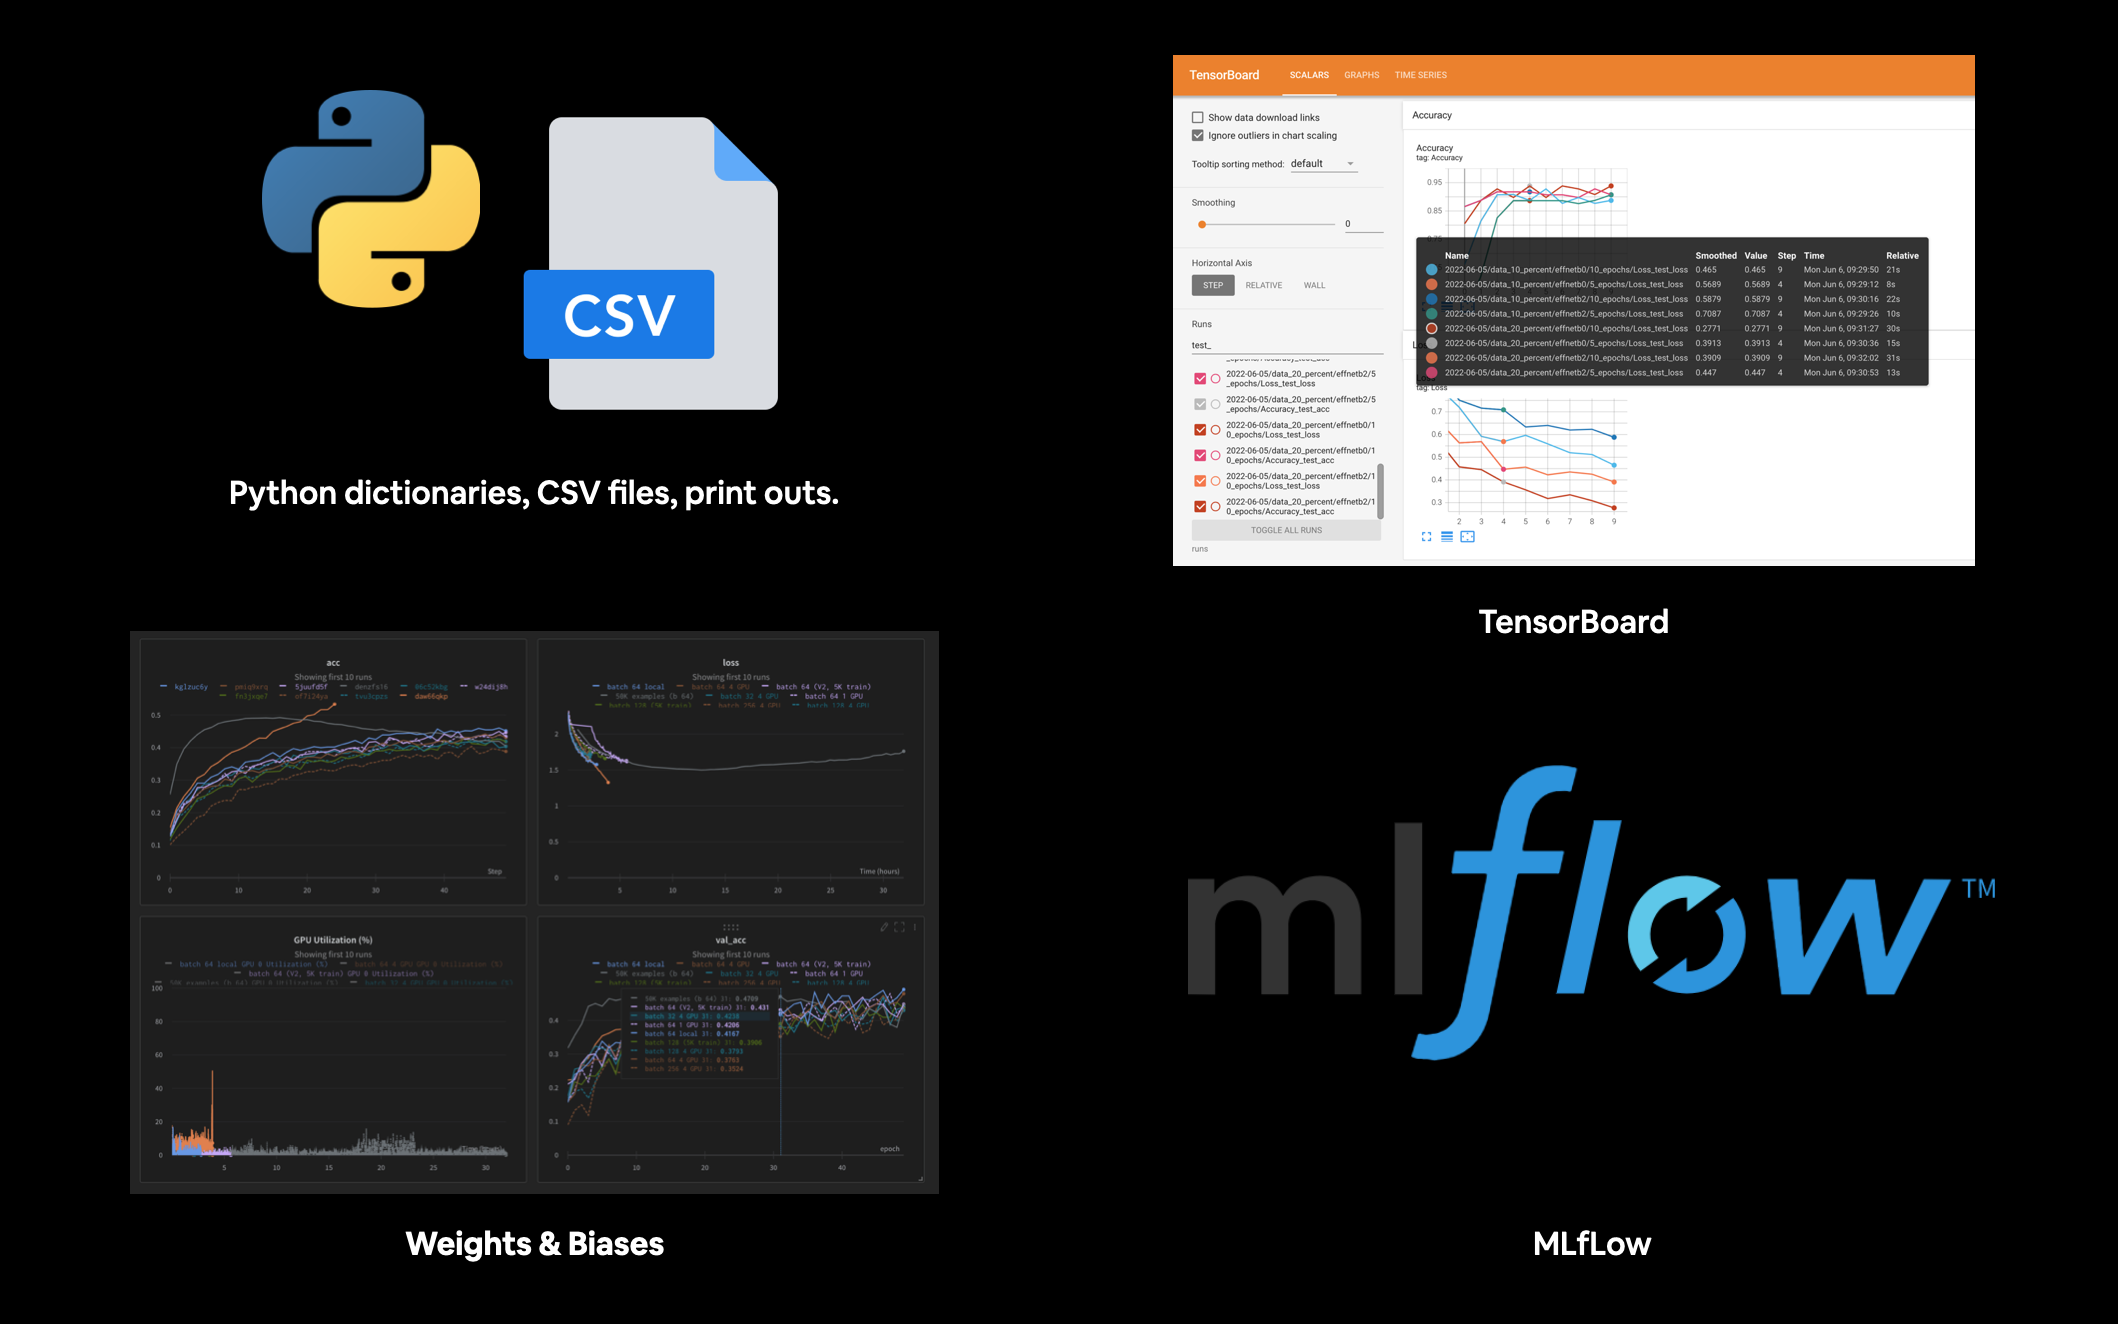

**Best blog for Experiment Tracking :-** https://madewithml.com/courses/mlops/experiment-tracking/

In [ ]:
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)

1.13.1+cu116
0.14.1+cu116


In [ ]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/Prakashdey497/PyTorch.git
    !mv PyTorch/going_modular .
    !rm -rf PyTorch
    from going_modular import data_setup, engine

In [ ]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
# Set seeds
def set_seeds(seed: int=42):
    """Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)

## 1. Get data

want to get pizza,steak,sushi images.

So we can run experiments building Foodvision Mini and see which model performes best.

In [ ]:
import os
import zipfile

from pathlib import Path

import requests

def download_data(source: str, 
                  destination: str,
                  remove_source: bool = True) -> Path:
    """Downloads a zipped dataset from source and unzips to destination.

    Args:
        source (str): A link to a zipped file containing data.
        destination (str): A target directory to unzip data to.
        remove_source (bool): Whether to remove the source after downloading and extracting.
    
    Returns:
        pathlib.Path to downloaded data.
    
    Example usage:
        download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                      destination="pizza_steak_sushi")
    """
    # Setup path to data folder
    data_path = Path("data/")
    image_path = data_path / destination

    # If the image folder doesn't exist, download it and prepare it... 
    if image_path.is_dir():
        print(f"[INFO] {image_path} directory exists, skipping download.")
    else:
        print(f"[INFO] Did not find {image_path} directory, creating one...")
        image_path.mkdir(parents=True, exist_ok=True)
        
        # Download pizza, steak, sushi data
        target_file = Path(source).name
        with open(data_path / target_file, "wb") as f:
            request = requests.get(source)
            print(f"[INFO] Downloading {target_file} from {source}...")
            f.write(request.content)

        # Unzip pizza, steak, sushi data
        with zipfile.ZipFile(data_path / target_file, "r") as zip_ref:
            print(f"[INFO] Unzipping {target_file} data...") 
            zip_ref.extractall(image_path)

        # Remove .zip file
        if remove_source:
            os.remove(data_path / target_file)
    
    return image_path

In [ ]:
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

## 2. Create Datasets and DataLoaders

###  2.1 Create DataLoaders using manually created transforms

The goal with transform is to ensure our custom data is formatted in a reproducible way as well as a way that will suit pretrained models.

In [ ]:
# Setup directories
train_dir = image_path / "train"
test_dir = image_path / "test"

# Setup ImageNet normalization levels (turns all images into similar distribution as ImageNet)
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])           
print(f"Manually created transforms: {manual_transforms}")

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=32
)

train_dataloader, test_dataloader, class_names

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


(<torch.utils.data.dataloader.DataLoader at 0x7f4bceecaf10>,
 ['pizza', 'steak', 'sushi'])

### 2.2 Create DataLoaders using autometically created transforms

The same principle applies for automatic transforms,
we want our custom data in the same format as a pretrained model
was trained on.

In [ ]:
# Setup dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

In [ ]:
# Setup pretrained weights (plenty of these available in torchvision.models)
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

# Get transforms from weights (these are the transforms that were used to obtain the weights)
automatic_transforms = weights.transforms() 
print(f"Automatically created transforms: {automatic_transforms}")

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=automatic_transforms, # use automatic created transforms
    batch_size=32
)

train_dataloader, test_dataloader, class_names

Automatically created transforms: ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


(<torch.utils.data.dataloader.DataLoader at 0x7f4bc8b773a0>,
 ['pizza', 'steak', 'sushi'])


## 3. Getting a pretrained model, freezing the base layers and changing the classifier head

In [ ]:
# Note: This is how a pretrained model would be created in torchvision > 0.13, it will be deprecated in future versions.
# model = torchvision.models.efficientnet_b0(pretrained=True).to(device) # OLD 

# Download the pretrained weights for EfficientNet_B0
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # NEW in torchvision 0.13, "DEFAULT" means "best weights available"

# Setup the model with the pretrained weights and send it to the target device
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

# View the output of the model
# model

In [ ]:
# Freeze all base layers by setting requires_grad attribute to False
for param in model.features.parameters():
    param.requires_grad = False
    
# Since we're creating a new layer with random weights (torch.nn.Linear), 
# let's set the seeds
set_seeds() 

# Update the classifier head to suit our problem
model.classifier = torch.nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, 
              out_features=len(class_names),
              bias=True).to(device))

In [ ]:
from torchinfo import summary

# Get a summary of the model (uncomment for full output)
summary(model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

## 4. Train model and track results

In [ ]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

To track experiments, we're going to use TensorBoard : https://www.tensorflow.org/tensorboard

And to interect with TensorBoard, we can use PyTorch SummaryWriter : https://pytorch.org/docs/stable/tensorboard.html



In [ ]:
# Setup a SummaryWriter

from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter()
writer

In [ ]:
from typing import Dict, List
from tqdm.auto import tqdm

from going_modular.engine import train_step, test_step

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
      model: A PyTorch model to be trained and tested.
      train_dataloader: A DataLoader instance for the model to be trained on.
      test_dataloader: A DataLoader instance for the model to be tested on.
      optimizer: A PyTorch optimizer to help minimize the loss function.
      loss_fn: A PyTorch loss function to calculate loss on both datasets.
      epochs: An integer indicating how many epochs to train for.
      device: A target device to compute on (e.g. "cuda" or "cpu").
      
    Returns:
      A dictionary of training and testing loss as well as training and
      testing accuracy metrics. Each metric has a value in a list for 
      each epoch.
      In the form: {train_loss: [...],
                train_acc: [...],
                test_loss: [...],
                test_acc: [...]} 
      For example if training for epochs=2: 
              {train_loss: [2.0616, 1.0537],
                train_acc: [0.3945, 0.3945],
                test_loss: [1.2641, 1.5706],
                test_acc: [0.3400, 0.2973]} 
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        ### New: Experiment tracking ###
        # Add loss results to SummaryWriter
        writer.add_scalars(main_tag="Loss", 
                           tag_scalar_dict={"train_loss": train_loss,
                                            "test_loss": test_loss},
                           global_step=epoch)

        # Add accuracy results to SummaryWriter
        writer.add_scalars(main_tag="Accuracy", 
                           tag_scalar_dict={"train_acc": train_acc,
                                            "test_acc": test_acc}, 
                           global_step=epoch)
        
        # Track the PyTorch model architecture
        writer.add_graph(model=model, 
                         # Pass in an example input
                         input_to_model=torch.randn(32, 3, 224, 224).to(device))
    
    # Close the writer
    writer.close()
    
    ### End new ###

    # Return the filled results at the end of the epochs
    return results

In [ ]:
# Train model
# Note: Not using engine.train() since the original script isn't updated to use writer
set_seeds()
results = train(model=model,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=5,
                device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0929 | train_acc: 0.4023 | test_loss: 0.9125 | test_acc: 0.5502
Epoch: 2 | train_loss: 0.8966 | train_acc: 0.6562 | test_loss: 0.7839 | test_acc: 0.8561
Epoch: 3 | train_loss: 0.8045 | train_acc: 0.7422 | test_loss: 0.6716 | test_acc: 0.8864
Epoch: 4 | train_loss: 0.6787 | train_acc: 0.7305 | test_loss: 0.6697 | test_acc: 0.8258
Epoch: 5 | train_loss: 0.7066 | train_acc: 0.7188 | test_loss: 0.6737 | test_acc: 0.7737


## 5. View our model's result with TensorBoard.

There are a few ways to view TensorBoard results. 

In [ ]:
# Example code to run in Jupyter or Google Colab Notebook (uncomment to try it out)
# %load_ext tensorboard
# %tensorboard --logdir runs

## 6. Create a helper function to build SummaryWriter() instances

By default our `SummaryWriter()` class saves to `log_dir()`.

How about if we wanted to save different experiment to different folder?

In essence, one experiment = one folder.

For example, we'd like to track:

* Experiment date/timestamp

* Experiment name

* Model name

* Extra - is there anything else that should be tracked?

Let's create a function to create a `SummaryWriter()` instance to take all of these things into account.

So ideally we end up tracking experiments to a directory:

`runs/YYYY-MM-DD/experiment_name/model_name/extra`

In [ ]:
def create_writer(experiment_name:str,
                  model_name:str,
                  extra:str = None):
  
  """ Creates a torch.utils.tensorboard.writer.SummaryWriter() instance tracking to a specific directory."""

  from datetime import datetime
  import os

  # Get timestamp of current data in reverse order
  timestamp = datetime.now().strftime("%Y-%m-%d")

  if extra:
    # Create a log directory path
    log_dir = os.path.join("runs",timestamp,experiment_name,model_name,extra)

  else:
    log_dir = os.path.join("runs",timestamp,experiment_name,model_name)

  print(f"[INFO] Created SummaryWriter saving to {log_dir}")

  return SummaryWriter(log_dir=log_dir)

In [ ]:
example_writer = create_writer(experiment_name="data_10_persent",
                               model_name="effnetb0",
                               extra="5_epochs")

example_writer

[INFO] Created SummaryWriter saving to runs/2023-03-16/data_10_persent/effnetb0/5_epochs


### 6.1 Update the train() function to include a writer parameter

In [ ]:
from typing import Dict, List
from tqdm.auto import tqdm

# Add writer parameter to train()
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device, 
          writer: torch.utils.tensorboard.writer.SummaryWriter # new parameter to take in a writer
          ) -> Dict[str, List]:
          
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)


        ### New: Use the writer parameter to track experiments ###
        # See if there's a writer, if so, log to it
        if writer:
            # Add results to SummaryWriter
            writer.add_scalars(main_tag="Loss", 
                               tag_scalar_dict={"train_loss": train_loss,
                                                "test_loss": test_loss},
                               global_step=epoch)
            writer.add_scalars(main_tag="Accuracy", 
                               tag_scalar_dict={"train_acc": train_acc,
                                                "test_acc": test_acc}, 
                               global_step=epoch)

            # Close the writer
            writer.close()
        else:
            pass
    ### End new ###

    # Return the filled results at the end of the epochs
    return results

## 7. Setting up a series of modelling experiments

* Challenge: Setup 2x modellling experiments with effnetb0  pizza, steack,sushi data and train one model for 5 epocs and another model for 10 epochs.

### 7.1 What kind of experiments should we run?

The number of machine learning experiments we can run,is like the number of different models we can build... almost limtless.

However,we can't test everything..

so what should we test?

* Change the number of epocs.

* Change the number of hidden layer.

* Change the amount of data(right now we're using 10% of the Food101 dataset for pizza,steak,sushi)

* Change the learning rate

* Try different kinds of data augmentation

* Choose a diferent model architecture.

### 7.2 What experiment are we going to run?

we're going to turn three trials:

1. Model size - EffnetB0 vs EffnetB2 (in term of number of parameters)

2. Dataset size - 10% of pizza,steak,sushi images vs 20 (generally more data = better results)

3. Training time - 5 epochs vs 10 epocs(generally longer training time = better results, up to a point)

**Our goal:** a model that is well performing but still small enough to run on a mobile device or web brouser, so FoodVision Mini can come to life.

If we had infinite compute + time, you should basically always choose the biggest model and biggest dataset we can.(http://www.incompleteideas.net/IncIdeas/BitterLesson.html)

### 7.3 Download different datasets

We'll need two forms of a training set:

1. A training set with 10% of the data of Food101 pizza, steak, sushi images (https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip).

2. A training set with 20% of the data of Food101 pizza, steak, sushi images(https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip).

In [ ]:
# Download 10 percent and 20 percent training data (if necessary)
data_10_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                                     destination="pizza_steak_sushi")

data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

[INFO] data/pizza_steak_sushi directory exists, skipping download.
[INFO] data/pizza_steak_sushi_20_percent directory exists, skipping download.


### 7.4 Transform Datasets and create DataLoaders

We'll to transform our data in a few ways:
1. Resize the images to (224,224)

2. Make sure image values are between [0,1]

3. Normalize the images so they have the same data distribution as ImageNet.


In [ ]:
# Setup training directory paths
train_dir_10_percent = data_10_percent_path / "train"
train_dir_20_percent = data_20_percent_path / "train"

# Setup testing directory paths (note: use the same test dataset for both to compare the results)
test_dir = data_10_percent_path / "test"

# Check the directories
print(f"Training directory 10%: {train_dir_10_percent}")
print(f"Training directory 20%: {train_dir_20_percent}")
print(f"Testing directory: {test_dir}")

Training directory 10%: data/pizza_steak_sushi/train
Training directory 20%: data/pizza_steak_sushi_20_percent/train
Testing directory: data/pizza_steak_sushi/test


In [ ]:
from torchvision import transforms

# Create a transform to normalize data distribution to be inline with ImageNet
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], # values per colour channel [red, green, blue]
                                 std=[0.229, 0.224, 0.225]) # values per colour channel [red, green, blue]

# Compose transforms into a pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Resize the images
    transforms.ToTensor(), # 2. Turn the images into tensors with values between 0 & 1
    normalize # 3. Normalize the images so their distributions match the ImageNet dataset 
])

In [ ]:
BATCH_SIZE = 32

# Create 10% training and test DataLoaders
train_dataloader_10_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_10_percent,
    test_dir=test_dir, 
    transform=simple_transform,
    batch_size=BATCH_SIZE
)

# Create 20% training and test data DataLoders
train_dataloader_20_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
    test_dir=test_dir,
    transform=simple_transform,
    batch_size=BATCH_SIZE
)

# Find the number of samples/batches per dataloader (using the same test_dataloader for both experiments)
print(f"Number of batches of size {BATCH_SIZE} in 10 percent training data: {len(train_dataloader_10_percent)}")
print(f"Number of batches of size {BATCH_SIZE} in 20 percent training data: {len(train_dataloader_20_percent)}")
print(f"Number of batches of size {BATCH_SIZE} in testing data: {len(train_dataloader_10_percent)} (all experiments will use the same test set)")
print(f"Number of classes: {len(class_names)}, class names: {class_names}")

Number of batches of size 32 in 10 percent training data: 8
Number of batches of size 32 in 20 percent training data: 15
Number of batches of size 32 in testing data: 8 (all experiments will use the same test set)
Number of classes: 3, class names: ['pizza', 'steak', 'sushi']


### 7.5 Create feature extractor models

We're going to create two feature extractor models:

1. Create a `torchvision.models.efficient_b0()` feature extractor with a frozen backbone/base layers and a custom classifier head(EffNetB0).

2. Create a `torchvision.models.efficient_b2()` feature extractor with a frozen backbone/base layers and a custom classifier head(EffNetB0).

In [ ]:
import torchvision

# Create an EffNetB2
effnetb2_weight = torchvision.models.EfficientNet_B2_Weights.DEFAULT

effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weight)

# effnetb2

In [ ]:
# 2. Get a summary of standard EffNetB2 from torchvision.models (uncomment for full output)
# summary(model=effnetb2, 
#         input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
#         # col_names=["input_size"], # uncomment for smaller output
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"]
# ) 


In [ ]:
import torchvision
from torch import nn

# Get num out features (one for each class pizza, steak, sushi)
OUT_FEATURES = len(class_names)

# Create an EffNetB0 feature extractor
def create_effnetb0():
  # 1. Get the base mdoel with pretrained weights and send to target device
  weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
  model = torchvision.models.efficientnet_b0(weights=weights).to(device)

  # 2. Freeze the base model layers
  for param in model.features.parameters():
      param.requires_grad = False

  # 3. Set the seeds
  set_seeds()

  # 4. Change the classifier head
  model.classifier = nn.Sequential(
      nn.Dropout(p=0.2),
      nn.Linear(in_features=1280, out_features=OUT_FEATURES)
  ).to(device)

  # 5. Give the model a name
  model.name = "effnetb0"
  print(f"[INFO] Created new {model.name} model.")
  return model

# Create an EffNetB2 feature extractor
def create_effnetb2():
    # 1. Get the base model with pretrained weights and send to target device
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    model = torchvision.models.efficientnet_b2(weights=weights).to(device)

    # 2. Freeze the base model layers
    for param in model.features.parameters():
        param.requires_grad = False

    # 3. Set the seeds
    set_seeds()

    # 4. Change the classifier head
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3),
        nn.Linear(in_features=1408, out_features=OUT_FEATURES)
    ).to(device)

    # 5. Give the model a name
    model.name = "effnetb2"
    print(f"[INFO] Created new {model.name} model.")
    return model

In [ ]:
effnetb0 = create_effnetb0()
effnetb2 = create_effnetb2()

[INFO] Created new effnetb0 model.
[INFO] Created new effnetb2 model.


In [ ]:
# summary(model=created_model_test, 
#         input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
#         # col_names=["input_size"], # uncomment for smaller output
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"]
# )

### 7.6 Create experiments and set up training code

In [ ]:
# 1. Create epochs list
num_epochs = [5, 10]

# 2. Create models list (need to create a new model for each experiment)
models = ["effnetb0", "effnetb2"]

# 3. Create dataloaders dictionary for various dataloaders
train_dataloaders = {"data_10_percent": train_dataloader_10_percent,
                     "data_20_percent": train_dataloader_20_percent}

In [ ]:
%%time
from going_modular.utils import save_model

# Set seeds
set_seeds(seed=128)

# Keep track of experiment numbers
experiment_number = 0

# Loop through each Dataloader

for dataloader_name,train_dataloader in train_dataloaders.items():
  
  # 4. Loop through each number of epochs
    for epochs in num_epochs: 

        # 5. Loop through each model name and create a new model based on the name
        for model_name in models:
          # 6. Create information print outs
            experiment_number += 1
            print(f"[INFO] Experiment number: {experiment_number}")
            print(f"[INFO] Model: {model_name}")
            print(f"[INFO] DataLoader: {dataloader_name}")
            print(f"[INFO] Number of epochs: {epochs}")

            # 7. Select the model
            if model_name == "effnetb0":
                model = create_effnetb0() # creates a new model each time (important because we want each experiment to start from scratch)
            else:
                model = create_effnetb2() # creates a new model each time (important because we want each experiment to start from scratch)
            
            # 8. Create a new loss and optimizer for every model
            loss_fn = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

            # 9. Train target model with target dataloaders and track experiments
            train(model=model,
                  train_dataloader=train_dataloader,
                  test_dataloader=test_dataloader, 
                  optimizer=optimizer,
                  loss_fn=loss_fn,
                  epochs=epochs,
                  device=device,
                  writer=create_writer(experiment_name=dataloader_name,
                                       model_name=model_name,
                                       extra=f"{epochs}_epochs"))
            
            # 10. Save the model to file so we can get back the best model
            save_filepath = f"07_{model_name}_{dataloader_name}_{epochs}_epochs.pth"
            save_model(model=model,
                       target_dir="models",
                       model_name=save_filepath)
            print("-"*50 + "\n")

[INFO] Experiment number: 1
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter saving to runs/2023-03-16/data_10_percent/effnetb0/5_epochs


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0520 | train_acc: 0.4961 | test_loss: 0.9212 | test_acc: 0.4782
Epoch: 2 | train_loss: 0.8743 | train_acc: 0.6875 | test_loss: 0.8136 | test_acc: 0.6203
Epoch: 3 | train_loss: 0.8097 | train_acc: 0.6523 | test_loss: 0.7196 | test_acc: 0.8258
Epoch: 4 | train_loss: 0.7096 | train_acc: 0.7578 | test_loss: 0.5920 | test_acc: 0.8864
Epoch: 5 | train_loss: 0.5999 | train_acc: 0.9062 | test_loss: 0.5689 | test_acc: 0.8864
[INFO] Saving model to: models/07_effnetb0_data_10_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 2
[INFO] Model: effnetb2
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb2 model.
[INFO] Created SummaryWriter saving to runs/2023-03-16/data_10_percent/effnetb2/5_epochs


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0914 | train_acc: 0.3867 | test_loss: 0.9558 | test_acc: 0.6610
Epoch: 2 | train_loss: 0.9239 | train_acc: 0.6445 | test_loss: 0.8713 | test_acc: 0.8144
Epoch: 3 | train_loss: 0.8080 | train_acc: 0.7578 | test_loss: 0.7511 | test_acc: 0.9072
Epoch: 4 | train_loss: 0.7182 | train_acc: 0.8867 | test_loss: 0.7161 | test_acc: 0.9081
Epoch: 5 | train_loss: 0.6847 | train_acc: 0.7656 | test_loss: 0.7087 | test_acc: 0.8873
[INFO] Saving model to: models/07_effnetb2_data_10_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 3
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 10
[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter saving to runs/2023-03-16/data_10_percent/effnetb0/10_epochs


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0520 | train_acc: 0.4961 | test_loss: 0.9212 | test_acc: 0.4782
Epoch: 2 | train_loss: 0.8743 | train_acc: 0.6875 | test_loss: 0.8136 | test_acc: 0.6203
Epoch: 3 | train_loss: 0.8097 | train_acc: 0.6523 | test_loss: 0.7196 | test_acc: 0.8258
Epoch: 4 | train_loss: 0.7096 | train_acc: 0.7578 | test_loss: 0.5920 | test_acc: 0.8864
Epoch: 5 | train_loss: 0.5999 | train_acc: 0.9062 | test_loss: 0.5689 | test_acc: 0.8864
Epoch: 6 | train_loss: 0.5619 | train_acc: 0.8945 | test_loss: 0.5964 | test_acc: 0.8864
Epoch: 7 | train_loss: 0.5578 | train_acc: 0.7891 | test_loss: 0.5590 | test_acc: 0.8864
Epoch: 8 | train_loss: 0.4700 | train_acc: 0.9492 | test_loss: 0.5199 | test_acc: 0.8759
Epoch: 9 | train_loss: 0.5729 | train_acc: 0.7695 | test_loss: 0.5120 | test_acc: 0.8873
Epoch: 10 | train_loss: 0.4782 | train_acc: 0.8242 | test_loss: 0.4650 | test_acc: 0.9072
[INFO] Saving model to: models/07_effnetb0_data_10_percent_10_epochs.pth
------------------------------------

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0914 | train_acc: 0.3867 | test_loss: 0.9558 | test_acc: 0.6610
Epoch: 2 | train_loss: 0.9239 | train_acc: 0.6445 | test_loss: 0.8713 | test_acc: 0.8144
Epoch: 3 | train_loss: 0.8080 | train_acc: 0.7578 | test_loss: 0.7511 | test_acc: 0.9072
Epoch: 4 | train_loss: 0.7182 | train_acc: 0.8867 | test_loss: 0.7161 | test_acc: 0.9081
Epoch: 5 | train_loss: 0.6847 | train_acc: 0.7656 | test_loss: 0.7087 | test_acc: 0.8873
Epoch: 6 | train_loss: 0.6115 | train_acc: 0.7891 | test_loss: 0.6332 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.6124 | train_acc: 0.8008 | test_loss: 0.6401 | test_acc: 0.8769
Epoch: 8 | train_loss: 0.5196 | train_acc: 0.9336 | test_loss: 0.6201 | test_acc: 0.8977
Epoch: 9 | train_loss: 0.5421 | train_acc: 0.8086 | test_loss: 0.6231 | test_acc: 0.8769
Epoch: 10 | train_loss: 0.4919 | train_acc: 0.8086 | test_loss: 0.5879 | test_acc: 0.8873
[INFO] Saving model to: models/07_effnetb2_data_10_percent_10_epochs.pth
------------------------------------

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9588 | train_acc: 0.6125 | test_loss: 0.6551 | test_acc: 0.8655
Epoch: 2 | train_loss: 0.6894 | train_acc: 0.8521 | test_loss: 0.5800 | test_acc: 0.8873
Epoch: 3 | train_loss: 0.5805 | train_acc: 0.8604 | test_loss: 0.4576 | test_acc: 0.9176
Epoch: 4 | train_loss: 0.4937 | train_acc: 0.8646 | test_loss: 0.4454 | test_acc: 0.9176
Epoch: 5 | train_loss: 0.4886 | train_acc: 0.8500 | test_loss: 0.3913 | test_acc: 0.9176
[INFO] Saving model to: models/07_effnetb0_data_20_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 6
[INFO] Model: effnetb2
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb2 model.
[INFO] Created SummaryWriter saving to runs/2023-03-16/data_20_percent/effnetb2/5_epochs


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9819 | train_acc: 0.5604 | test_loss: 0.7775 | test_acc: 0.8049
Epoch: 2 | train_loss: 0.7298 | train_acc: 0.8021 | test_loss: 0.6665 | test_acc: 0.8873
Epoch: 3 | train_loss: 0.6011 | train_acc: 0.8458 | test_loss: 0.5633 | test_acc: 0.9280
Epoch: 4 | train_loss: 0.5429 | train_acc: 0.8354 | test_loss: 0.5685 | test_acc: 0.8977
Epoch: 5 | train_loss: 0.4410 | train_acc: 0.8708 | test_loss: 0.4470 | test_acc: 0.9384
[INFO] Saving model to: models/07_effnetb2_data_20_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 7
[INFO] Model: effnetb0
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 10
[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter saving to runs/2023-03-16/data_20_percent/effnetb0/10_epochs


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9588 | train_acc: 0.6125 | test_loss: 0.6551 | test_acc: 0.8655
Epoch: 2 | train_loss: 0.6894 | train_acc: 0.8521 | test_loss: 0.5800 | test_acc: 0.8873
Epoch: 3 | train_loss: 0.5805 | train_acc: 0.8604 | test_loss: 0.4576 | test_acc: 0.9176
Epoch: 4 | train_loss: 0.4937 | train_acc: 0.8646 | test_loss: 0.4454 | test_acc: 0.9176
Epoch: 5 | train_loss: 0.4886 | train_acc: 0.8500 | test_loss: 0.3913 | test_acc: 0.9176
Epoch: 6 | train_loss: 0.3708 | train_acc: 0.8833 | test_loss: 0.3565 | test_acc: 0.9072
Epoch: 7 | train_loss: 0.3558 | train_acc: 0.9208 | test_loss: 0.3182 | test_acc: 0.9072
Epoch: 8 | train_loss: 0.3739 | train_acc: 0.8938 | test_loss: 0.3346 | test_acc: 0.8977
Epoch: 9 | train_loss: 0.2975 | train_acc: 0.9375 | test_loss: 0.3088 | test_acc: 0.9280
Epoch: 10 | train_loss: 0.3625 | train_acc: 0.8479 | test_loss: 0.2771 | test_acc: 0.9072
[INFO] Saving model to: models/07_effnetb0_data_20_percent_10_epochs.pth
------------------------------------

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9819 | train_acc: 0.5604 | test_loss: 0.7775 | test_acc: 0.8049
Epoch: 2 | train_loss: 0.7298 | train_acc: 0.8021 | test_loss: 0.6665 | test_acc: 0.8873
Epoch: 3 | train_loss: 0.6011 | train_acc: 0.8458 | test_loss: 0.5633 | test_acc: 0.9280
Epoch: 4 | train_loss: 0.5429 | train_acc: 0.8354 | test_loss: 0.5685 | test_acc: 0.8977
Epoch: 5 | train_loss: 0.4410 | train_acc: 0.8708 | test_loss: 0.4470 | test_acc: 0.9384
Epoch: 6 | train_loss: 0.3876 | train_acc: 0.9125 | test_loss: 0.4564 | test_acc: 0.8977
Epoch: 7 | train_loss: 0.3481 | train_acc: 0.9271 | test_loss: 0.4227 | test_acc: 0.9384
Epoch: 8 | train_loss: 0.3861 | train_acc: 0.8792 | test_loss: 0.4350 | test_acc: 0.9280
Epoch: 9 | train_loss: 0.3315 | train_acc: 0.8979 | test_loss: 0.4254 | test_acc: 0.9081
Epoch: 10 | train_loss: 0.3382 | train_acc: 0.8979 | test_loss: 0.3909 | test_acc: 0.9384
[INFO] Saving model to: models/07_effnetb2_data_20_percent_10_epochs.pth
------------------------------------

In [ ]:
# Viewing TensorBoard in Jupyter and Google Colab Notebooks (uncomment to view full TensorBoard instance)
# %load_ext tensorboard
# %tensorboard --logdir runs

In [ ]:
# # Upload the results to TensorBoard.dev (uncomment to try it out)
!tensorboard dev upload --logdir runs \
    --name "07. PyTorch Experiment Tracking: FoodVision Mini model results" \
    --description "Comparing results of different model size, training data amount and training time."

2023-03-16 15:24:45.467755: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-03-16 15:24:45.467851: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-03-16 15:24:45.467868: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
Upload started and will continue reading any new data as it's added to the logdir.

To stop uploading, press Ctrl-C.

New experiment created. View your TensorBoard at:

## 9. Load in the best model and make predictions with it

This is our best model filepath : `model/07_effnetb0_data_20_percent_10_epochs.pth`

In [ ]:
# Setup the best model filepath
best_model_path = "models/07_effnetb2_data_20_percent_10_epochs.pth"

# Instantiate a new instance of EffNetB2 (to load the saved state_dict() to)
best_model = create_effnetb2()

# Load the saved best model state_dict()
best_model.load_state_dict(torch.load(best_model_path))

[INFO] Created new effnetb2 model.


<All keys matched successfully>

Our Goal: Create a Foodvision mini model  that performs well enough and is able to run on a mobile device/web brouser.

In [ ]:
# Check the model file size
from pathlib import Path

# Get the model size in bytes then convert to megabytes
effnetb2_model_size = Path(best_model_path).stat().st_size // (1024*1024)
print(f"EfficientNetB2 feature extractor model size: {effnetb2_model_size} MB")

EfficientNetB2 feature extractor model size: 29 MB


In [ ]:
import torch
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt

from typing import List, Tuple

from PIL import Image

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Predict on a target image with a target model
# Function created in: https://www.learnpytorch.io/06_pytorch_transfer_learning/#6-make-predictions-on-images-from-the-test-set
def pred_and_plot_image(
    model: torch.nn.Module,
    class_names: List[str],
    image_path: str,
    image_size: Tuple[int, int] = (224, 224),
    transform: torchvision.transforms = None,
    device: torch.device = device,
):
    """Predicts on a target image with a target model.
    Args:
        model (torch.nn.Module): A trained (or untrained) PyTorch model to predict on an image.
        class_names (List[str]): A list of target classes to map predictions to.
        image_path (str): Filepath to target image to predict on.
        image_size (Tuple[int, int], optional): Size to transform target image to. Defaults to (224, 224).
        transform (torchvision.transforms, optional): Transform to perform on image. Defaults to None which uses ImageNet normalization.
        device (torch.device, optional): Target device to perform prediction on. Defaults to device.
    """

    # Open image
    img = Image.open(image_path)

    # Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose(
            [
                transforms.Resize(image_size),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                ),
            ]
        )

    ### Predict on image ###

    # Make sure the model is on the target device
    model.to(device)

    # Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
        transformed_image = image_transform(img).unsqueeze(dim=0)

        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(transformed_image.to(device))

    # Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # Plot image with predicted label and probability
    plt.figure()
    plt.imshow(img)
    plt.title(
        f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}"
    )
    plt.axis(False)

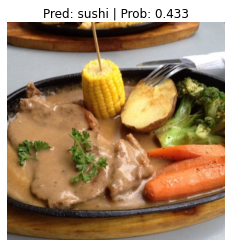

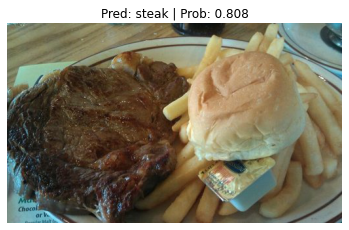

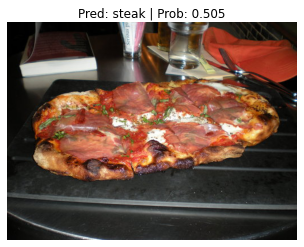

In [ ]:
# Get a random list of 3 images from 20% test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path(data_20_percent_path / "test").glob("*/*.jpg")) # get all test image paths from 20% dataset
test_image_path_sample = random.sample(population=test_image_path_list,
                                       k=num_images_to_plot) # randomly select k number of images

# Iterate through random test image paths, make predictions on them and plot them
for image_path in test_image_path_sample:
    pred_and_plot_image(model=best_model,
                        image_path=image_path,
                        class_names=class_names,
                        image_size=(224, 224))